In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/temporal-fusion-transformer/batch_14.parquet
/kaggle/input/temporal-fusion-transformer/batch_21.parquet
/kaggle/input/temporal-fusion-transformer/batch_20.parquet
/kaggle/input/temporal-fusion-transformer/batch_03.parquet
/kaggle/input/temporal-fusion-transformer/batch_07.parquet
/kaggle/input/temporal-fusion-transformer/batch_18.parquet
/kaggle/input/temporal-fusion-transformer/batch_12.parquet
/kaggle/input/temporal-fusion-transformer/batch_11.parquet
/kaggle/input/temporal-fusion-transformer/batch_10.parquet
/kaggle/input/temporal-fusion-transformer/batch_08.parquet
/kaggle/input/temporal-fusion-transformer/batch_09.parquet
/kaggle/input/temporal-fusion-transformer/batch_06.parquet
/kaggle/input/temporal-fusion-transformer/batch_15.parquet
/kaggle/input/temporal-fusion-transformer/batch_17.parquet
/kaggle/input/temporal-fusion-transformer/batch_02.parquet
/kaggle/input/temporal-fusion-transformer/batch_05.parquet
/kaggle/input/temporal-fusion-transformer/batch_16.parqu

In [2]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import pickle
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

class TimeSeriesDataset(Dataset):
    def __init__(self, data, input_len=432, pred_len=144):
        self.input_len = input_len
        self.pred_len = pred_len
        self.sequences = self.create_sequences(data)

    def create_sequences(self, data):
        sequences = []
        total_len = self.input_len + self.pred_len
        for i in range(len(data) - total_len + 1):
            input_seq = data[i:i + self.input_len]
            target_seq = data[i + self.input_len:i + total_len]
            sequences.append((input_seq, target_seq))
        return sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        x, y = self.sequences[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, pred_len=144):
        super().__init__()
        self.input_dim = input_dim
        self.pred_len = pred_len
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, input_dim * pred_len)

    def forward(self, x):
        B, T, C = x.shape
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.linear(out)
        return out.reshape(B, self.pred_len, self.input_dim)

def train_model(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate_model(model, dataloader, criterion, device, scaler=None):
    model.eval()
    mse_list = []
    total_loss = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            total_loss += loss.item()
            y_pred_np = y_pred.cpu().numpy()
            y_true_np = y.cpu().numpy()
            if scaler:
                y_pred_np = scaler.inverse_transform(y_pred_np.reshape(-1, y_pred_np.shape[-1])).reshape(y_pred_np.shape)
                y_true_np = scaler.inverse_transform(y_true_np.reshape(-1, y_true_np.shape[-1])).reshape(y_true_np.shape)
            mse = mean_squared_error(y_true_np.flatten(), y_pred_np.flatten())
            mse_list.append(mse)
    return total_loss / len(dataloader), np.mean(mse_list)

def train_and_save_models(batch_folder, output_dir="models", input_len=432, pred_len=144, num_epochs=10, num_ids=100):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    features = ['SMS-in activity', 'SMS-out activity', 'Call-in activity', 'Call-out activity', 'Internet traffic activity']

    batch_files = [f for f in sorted(os.listdir(batch_folder)) if f.endswith(".parquet")]
    if not batch_files:
        print("Không tìm thấy file parquet trong thư mục")
        return

    first_batch_path = os.path.join(batch_folder, batch_files[0])
    print(f"Đang đọc batch đầu tiên: {batch_files[0]}")
    first_df = pd.read_parquet(first_batch_path)
    unique_square_ids = first_df['Square id'].unique()
    selected_square_ids = np.random.choice(unique_square_ids, size=min(num_ids, len(unique_square_ids)), replace=False)

    all_data = []
    for batch_file in batch_files:
        batch_path = os.path.join(batch_folder, batch_file)
        df = pd.read_parquet(batch_path)
        df['Time Interval'] = pd.to_datetime(df['Time Interval'], unit='ms')
        df = df[df['Square id'].isin(selected_square_ids)]
        all_data.append(df)

    combined_df = pd.concat(all_data, ignore_index=True)
    combined_df = combined_df.sort_values(['Square id', 'Time Interval'])

    for square_id in selected_square_ids:
        print(f"\n=== Huấn luyện cho Square id {square_id} ===")
        group = combined_df[combined_df['Square id'] == square_id].sort_values('Time Interval')
        data = group[features].values

        scaler = StandardScaler()
        data = scaler.fit_transform(data)

        dataset = TimeSeriesDataset(data, input_len, pred_len)
        if len(dataset) < 10:
            print(f"Bỏ qua Square id {square_id}: không đủ dữ liệu ({len(dataset)} chuỗi)")
            continue

        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

        model = LSTMModel(input_dim=len(features), pred_len=pred_len).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.MSELoss()

        best_val_loss = float('inf')
        patience = 3
        patience_counter = 0

        train_losses = []
        val_losses = []

        for epoch in range(num_epochs):
            train_loss = train_model(model, train_loader, optimizer, criterion, device)
            val_loss, val_mse = evaluate_model(model, val_loader, criterion, device, scaler)
            print(f"[Square id: {square_id}, Epoch {epoch+1}] Train_loss: {train_loss:.4f}, Test_loss: {val_loss:.4f}")

            train_losses.append(train_loss)
            val_losses.append(val_loss)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                model_path = os.path.join(output_dir, f"lstm_square_{square_id}.pth")
                scaler_path = os.path.join(output_dir, f"scaler_square_{square_id}.pkl")
                torch.save(model.state_dict(), model_path)
                with open(scaler_path, 'wb') as f:
                    pickle.dump(scaler, f)
                # Save train/val loss history
                np.save(os.path.join(output_dir, f"train_loss_{square_id}.npy"), np.array(train_losses))
                np.save(os.path.join(output_dir, f"val_loss_{square_id}.npy"), np.array(val_losses))
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Dừng sớm tại epoch {epoch+1} cho Square id {square_id}")
                    break

def predict(square_id, hour, day_of_week, batch_folder, model_dir="models", input_len=432, pred_len=144):
    days = ['thứ hai', 'thứ ba', 'thứ tư', 'thứ năm', 'thứ sáu', 'thứ bảy', 'chủ nhật']
    try:
        day_idx = days.index(day_of_week.lower())
    except ValueError:
        return f"Ngày trong tuần không hợp lệ: {day_of_week}. Phải là một trong {days}"

    if not (0 <= hour <= 23):
        return f"Giờ không hợp lệ: {hour}. Phải nằm trong khoảng 0-23"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    features = ['SMS-in activity', 'SMS-out activity', 'Call-in activity', 'Call-out activity', 'Internet traffic activity']

    model_path = os.path.join(model_dir, f"lstm_square_{square_id}.pth")
    scaler_path = os.path.join(model_dir, f"scaler_square_{square_id}.pkl")

    if not os.path.exists(model_path) or not os.path.exists(scaler_path):
        return f"Không tìm thấy mô hình hoặc scaler cho Square id {square_id}"

    model = LSTMModel(input_dim=len(features), pred_len=pred_len).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)

    group = []
    for batch_file in sorted(os.listdir(batch_folder)):
        if batch_file.endswith(".parquet"):
            batch_path = os.path.join(batch_folder, batch_file)
            df = pd.read_parquet(batch_path)
            df['Time Interval'] = pd.to_datetime(df['Time Interval'], unit='ms')
            group.append(df[df['Square id'] == square_id])

    if not group:
        return f"Không tìm thấy Square id {square_id} trong bất kỳ batch nào"

    group = pd.concat(group, ignore_index=True)
    group = group.sort_values('Time Interval')
    group['Day of Week'] = group['Time Interval'].dt.dayofweek
    group['Hour'] = group['Time Interval'].dt.hour

    target_time = group[(group['Day of Week'] == day_idx) & (group['Hour'] == hour)]
    if target_time.empty:
        return f"Không tìm thấy dữ liệu cho Square id {square_id} vào {day_of_week} lúc {hour}:00"

    latest_time = target_time['Time Interval'].max()
    input_data = group[group['Time Interval'] <= latest_time].tail(input_len)

    if len(input_data) < input_len:
        return f"Không đủ dữ liệu cho Square id {square_id} (chỉ có {len(input_data)} bước thời gian, cần {input_len})"

    data = input_data[features].values
    data = scaler.transform(data)
    x = torch.tensor(data, dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        y_pred = model(x).cpu().numpy()
    y_pred = scaler.inverse_transform(y_pred[0]).reshape(pred_len, len(features))

    pred_times = [latest_time + timedelta(minutes=10 * i) for i in range(1, pred_len + 1)]
    result = []
    for i, t in enumerate(pred_times):
        row = [t.strftime('%H:%M')]
        for j, feature in enumerate(features):
            row.append(f"{y_pred[i, j]:.2f}")
        result.append(row)

    columns = ['Thời gian'] + features
    result_df = pd.DataFrame(result, columns=columns)
    return result_df

def main():
    batch_folder = "/kaggle/input/temporal-fusion-transformer"
    model_dir = "models"

    if not os.path.exists(model_dir) or not any(f.endswith('.pth') for f in os.listdir(model_dir)):
        print("Đang huấn luyện các mô hình cho 100 Square id ngẫu nhiên...")
        train_and_save_models(batch_folder, model_dir)

    while True:
        print("\nNhập thông tin dự báo (hoặc 'thoát' để kết thúc):")
        square_id = input("Square id: ")
        if square_id.lower() == 'thoát':
            break
        try:
            square_id = int(square_id)
        except ValueError:
            print("Square id phải là số nguyên")
            continue

        hour = input("Giờ (0-23): ")
        try:
            hour = int(hour)
        except ValueError:
            print("Giờ phải là số nguyên")
            continue

        day_of_week = input("Ngày trong tuần (VD: Thứ hai): ")
        result = predict(square_id, hour, day_of_week, batch_folder, model_dir)
        if isinstance(result, str):
            print(result)
        else:
            print("\nDự báo cho 24 giờ tiếp theo:")
            print(result.to_string(index=False))
    
if __name__ == "__main__":
    main()

Đang huấn luyện các mô hình cho 100 Square id ngẫu nhiên...
Đang đọc batch đầu tiên: batch_01.parquet

=== Huấn luyện cho Square id 2958 ===
[Square id: 2958, Epoch 1] Train_loss: 0.6492, Test_loss: 0.5365
[Square id: 2958, Epoch 2] Train_loss: 0.5122, Test_loss: 0.5116
[Square id: 2958, Epoch 3] Train_loss: 0.4938, Test_loss: 0.4988
[Square id: 2958, Epoch 4] Train_loss: 0.4820, Test_loss: 0.4888
[Square id: 2958, Epoch 5] Train_loss: 0.4665, Test_loss: 0.4562
[Square id: 2958, Epoch 6] Train_loss: 0.4233, Test_loss: 0.4123
[Square id: 2958, Epoch 7] Train_loss: 0.3945, Test_loss: 0.3965
[Square id: 2958, Epoch 8] Train_loss: 0.3952, Test_loss: 0.3930
[Square id: 2958, Epoch 9] Train_loss: 0.3810, Test_loss: 0.3870
[Square id: 2958, Epoch 10] Train_loss: 0.3766, Test_loss: 0.3882

=== Huấn luyện cho Square id 8555 ===
[Square id: 8555, Epoch 1] Train_loss: 0.8761, Test_loss: 0.7459
[Square id: 8555, Epoch 2] Train_loss: 0.6488, Test_loss: 0.6076
[Square id: 8555, Epoch 3] Train_loss: 

Square id:  1959
Giờ (0-23):  22
Ngày trong tuần (VD: Thứ hai):  thứ hai



Dự báo cho 24 giờ tiếp theo:
Thời gian SMS-in activity SMS-out activity Call-in activity Call-out activity Internet traffic activity
    23:00            0.28             0.24             0.12              0.11                      7.36
    23:10            0.26             0.20             0.02              0.05                      7.22
    23:20            0.25             0.16             0.06              0.05                      6.91
    23:30            0.24             0.18             0.05              0.07                      6.38
    23:40            0.25             0.17             0.04             -0.01                      6.39
    23:50            0.16             0.11             0.02              0.04                      6.10
    00:00            0.10             0.13             0.00             -0.01                      5.85
    00:10            0.17             0.13             0.05              0.07                      5.94
    00:20            0.17         

Square id:  thoát


In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_trained_model(square_id, batch_folder, model_dir="models", input_len=432, pred_len=144):
    features = ['SMS-in activity', 'SMS-out activity', 'Call-in activity', 'Call-out activity', 'Internet traffic activity']
    model_path = os.path.join(model_dir, f"lstm_square_{square_id}.pth")
    scaler_path = os.path.join(model_dir, f"scaler_square_{square_id}.pkl")

    if not os.path.exists(model_path) or not os.path.exists(scaler_path):
        print(f"Không tìm thấy model hoặc scaler cho Square id {square_id}")
        return

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTMModel(input_dim=len(features), pred_len=pred_len).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)

    group = []
    for batch_file in sorted(os.listdir(batch_folder)):
        if batch_file.endswith(".parquet"):
            df = pd.read_parquet(os.path.join(batch_folder, batch_file))
            df['Time Interval'] = pd.to_datetime(df['Time Interval'], unit='ms')
            group.append(df[df['Square id'] == square_id])

    if not group:
        print(f"Không có dữ liệu cho Square id {square_id}")
        return

    df = pd.concat(group, ignore_index=True).sort_values("Time Interval")
    data = df[features].values
    timestamps = df['Time Interval'].values

    scaled_data = scaler.transform(data)
    dataset = TimeSeriesDataset(scaled_data, input_len, pred_len)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    all_preds, all_trues, all_times = [], [], []
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            y_pred_np = y_pred.cpu().numpy().reshape(-1, len(features))
            y_true_np = y.cpu().numpy().reshape(-1, len(features))
            y_pred_np = scaler.inverse_transform(y_pred_np)
            y_true_np = scaler.inverse_transform(y_true_np)

            # Lấy thời gian tương ứng (10 phút mỗi bước)
            start_idx = i + input_len
            pred_times = [timestamps[start_idx] + np.timedelta64(10 * j, 'm') for j in range(pred_len)]
            all_preds.append(y_pred_np)
            all_trues.append(y_true_np)
            all_times.extend(pred_times)

    y_pred_all = np.concatenate(all_preds)
    y_true_all = np.concatenate(all_trues)

    mse = mean_squared_error(y_true_all, y_pred_all)
    mae = mean_absolute_error(y_true_all, y_pred_all)
    print(f"\nSquare ID {square_id} Evaluation:")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")

    # Vẽ biểu đồ từng đặc trưng
    plt.figure(figsize=(16, 10))
    for i, feature in enumerate(features):
        plt.subplot(3, 2, i + 1)
        plt.plot(all_times, y_true_all[:, i], label='Thực tế', color='blue')
        plt.plot(all_times, y_pred_all[:, i], label='Dự đoán', color='orange')
        plt.title(feature)
        plt.xlabel('Thời gian')
        plt.ylabel('Giá trị')
        plt.grid(True)
        if i == 0:
            plt.legend()
    plt.tight_layout()
    plt.show()


Square ID 1959 Evaluation:
MSE: 0.9091
MAE: 0.4382


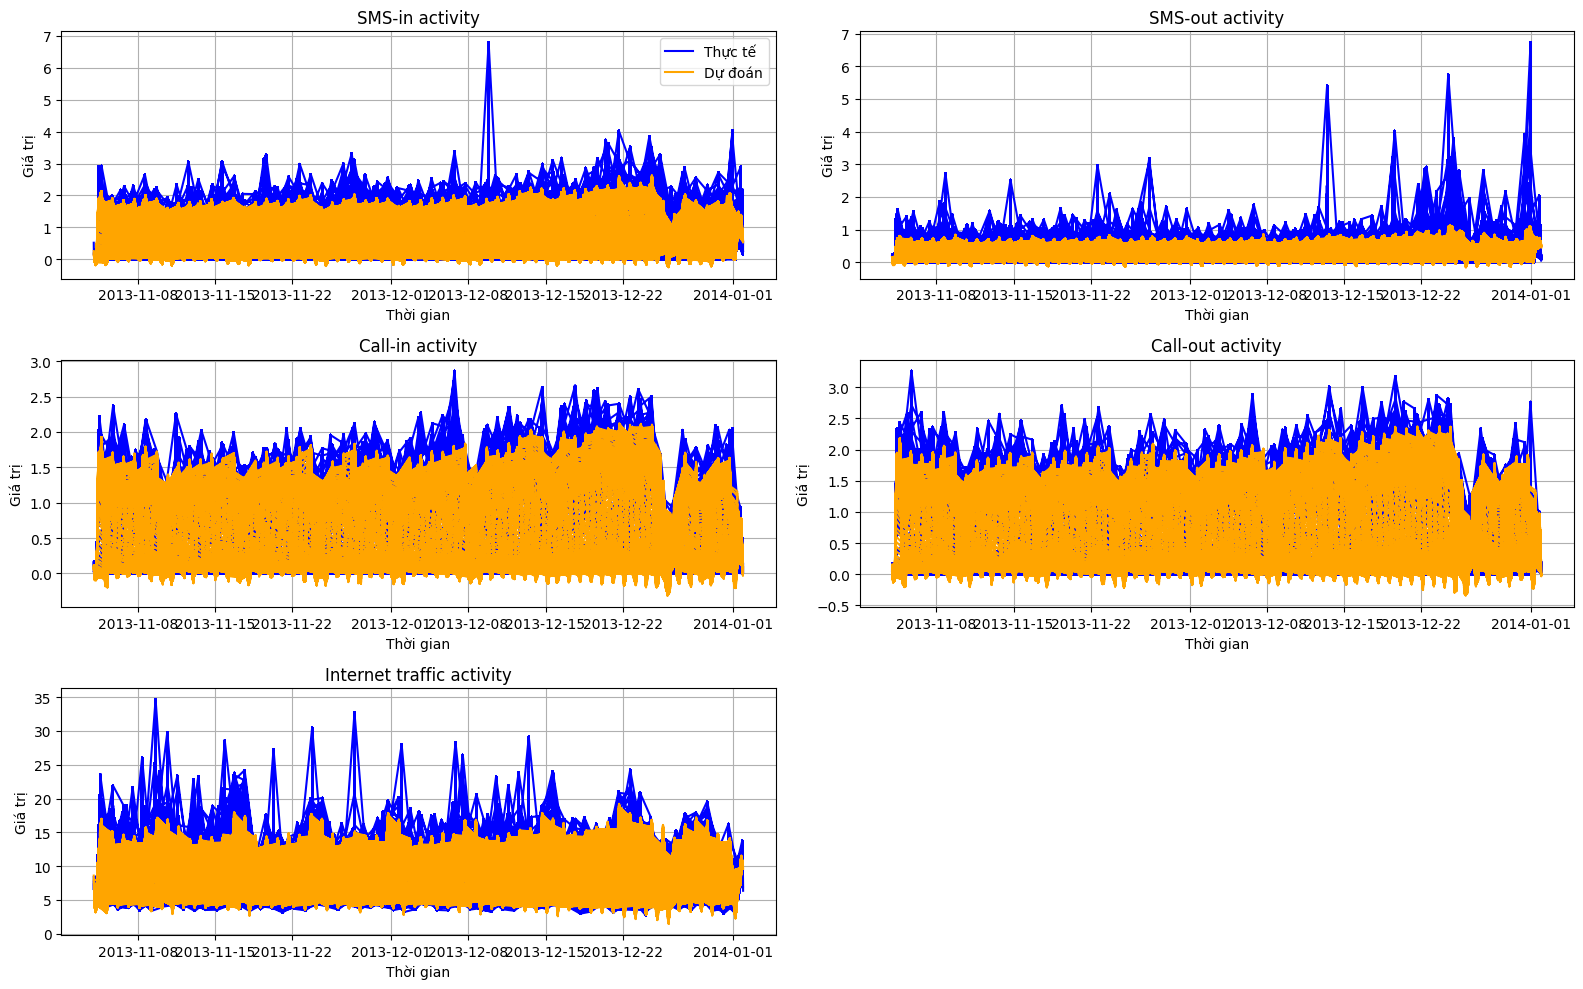

In [11]:
evaluate_trained_model(square_id=1959, batch_folder="/kaggle/input/temporal-fusion-transformer")

In [15]:
!zip -r models.zip models/

  adding: models/ (stored 0%)
  adding: models/scaler_square_3664.pkl (deflated 20%)
  adding: models/train_loss_9017.npy (deflated 29%)
  adding: models/train_loss_4530.npy (deflated 29%)
  adding: models/train_loss_4899.npy (deflated 26%)
  adding: models/lstm_square_1959.pth (deflated 8%)
  adding: models/train_loss_1367.npy (deflated 26%)
  adding: models/train_loss_7913.npy (deflated 27%)
  adding: models/scaler_square_8063.pkl (deflated 19%)
  adding: models/val_loss_2001.npy (deflated 26%)
  adding: models/lstm_square_4541.pth (deflated 7%)
  adding: models/train_loss_8890.npy (deflated 26%)
  adding: models/lstm_square_398.pth (deflated 8%)
  adding: models/val_loss_2531.npy (deflated 27%)
  adding: models/val_loss_254.npy (deflated 29%)
  adding: models/train_loss_4595.npy (deflated 27%)
  adding: models/scaler_square_3857.pkl (deflated 19%)
  adding: models/train_loss_9984.npy (deflated 29%)
  adding: models/lstm_square_8083.pth (deflated 7%)
  adding: models/val_loss_5744.np